In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [1]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Import Dataset H1N1
df_guar_h1 = pd.read_csv("guardian_h1n1_articles.csv")
df_bbc_h1  = pd.read_csv("BBCNews_h1n1_articles.csv")
df_nyt_h1  = pd.read_csv("nytimes_h1n1_articles.csv")
#df_usat_h1 = pd.read_csv("usatoday_h1n1_articles.csv")

df_all = pd.concat([df_guar_h1, df_nyt_h1, df_bbc_h1, df_usat_h1])

In [14]:
# Import Dataset COVID
df_guar_co = pd.read_csv("guardian_covid_articles.csv")
df_bbc_co  = pd.read_csv("BBCNews_covid_articles.csv")
df_nyt_co  = pd.read_csv("nytimes_covid_articles.csv")
df_usat_co = pd.read_csv("usatoday_covid_articles.csv")

df_all = pd.concat([df_guar_co, df_nyt_co, df_bbc_co, df_usat_co])

In [24]:
# Convert to string & to list
df_all["content"] = df_all["content"].apply(str)
data = df_all.content.values.tolist()

print(len(data))

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data_words = list(sent_to_words(data))

55435


KeyboardInterrupt: 

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['friend', 'say', 'half', 'man', 'use', 'lose', 'stone', 'past', 'couple', 'year', 'fitter', 'energise', 'emerge', 'retrain', 'less', 'friendly', 'disposition', 'would', 'also', 'say', 'half', 'man', 'use', 'accuse', 'labour', 'former', 'deputy', 'leader', 'betray', 'party', 'undermine', 'time', 'long', 'term', 'critic', 'would', 'say', 'never', 'much', 'man', 'wish', 'could', 'dispense', 'year', 'ago', 'day', 'night', 'inquest', 'labour', 'trounce', 'already', 'begin', 'upset', 'emotional', 'exhausted', 'night', 'phone', 'friend', 'lose', 'seat', 'offer', 'support', 'lot', 'even', 'east', 'seat', 'hold', 'year', 'go', 'first', 'time', 'talk', 'reason', 'defeat', 'familiar', 'list', 'include', 'overpromise', 'antisemitism', 'failure', 'leave', 'even', 'know', 'message', 'campaign', 'say', 'announcement', 'everywhere', 'none', 'get', 'many', 'know', 'get', 'do', 'labour', 'strapline', 'politic', 'get', 'simplistic', 'politic', 'complicate', 'able', 'condense', 'stand', 'single', 'messa

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Remove uncommon and too frequent words
id2word.filter_extremes(no_below=20, no_above=0.5)

print(id2word)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

Dictionary(18986 unique tokens: ['able', 'abuse', 'abuser', 'accuse', 'achieve']...)
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 6), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 2), (46, 3), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 5), (58, 1), (59, 1), (60, 2), (61, 1), (62, 4), (63, 2), (64, 1), (65, 2), (66, 1), (67, 2), (68, 5), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 3), (78, 3), (79, 1), (80, 1), (81, 1), (82, 3), (83, 3), (84, 1), (85, 1), (86, 1), (87, 1), (88, 4), (89, 1), (90, 10), (91, 1), (92, 3), (93, 1), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 1), (100, 1), (101, 1), (1

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"get" + 0.021*"know" + 0.018*"want" + 0.016*"think" + 0.013*"see" + '
  '0.013*"tell" + 0.013*"thing" + 0.012*"come" + 0.011*"work" + 0.010*"way"'),
 (1,
  '0.040*"health" + 0.034*"case" + 0.033*"virus" + 0.020*"patient" + '
  '0.020*"hospital" + 0.019*"medical" + 0.019*"spread" + 0.016*"care" + '
  '0.016*"death" + 0.015*"day"'),
 (2,
  '0.043*"fire" + 0.041*"state" + 0.034*"resident" + 0.028*"area" + '
  '0.021*"city" + 0.017*"home" + 0.017*"storm" + 0.016*"water" + 0.016*"local" '
  '+ 0.015*"tree"'),
 (3,
  '0.048*"travel" + 0.042*"passenger" + 0.038*"flight" + 0.027*"crash" + '
  '0.025*"car" + 0.025*"plane" + 0.020*"driver" + 0.018*"fly" + 0.017*"crew" + '
  '0.017*"trip"'),
 (4,
  '0.259*"woman" + 0.086*"black" + 0.059*"man" + 0.040*"color" + 0.034*"white" '
  '+ 0.032*"female" + 0.030*"sex" + 0.030*"book" + 0.027*"girl" + '
  '0.018*"young"'),
 (5,
  '0.060*"child" + 0.053*"family" + 0.042*"home" + 0.028*"parent" + '
  '0.022*"food" + 0.021*"will" + 0.019*"kid" + 

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.231924540869707

Coherence Score:  0.5048652738066616


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.142277 -0.030636       1        1  18.391169
8      0.152619  0.053460       2        1  13.966307
9      0.134880  0.029619       3        1   8.793136
18     0.020880  0.023898       4        1   8.370074
11     0.145281 -0.053409       5        1   8.326874
12     0.122750 -0.133376       6        1   5.856507
1      0.045989 -0.106916       7        1   4.508636
15    -0.027389  0.196072       8        1   4.071848
10     0.040514  0.253294       9        1   3.852301
17     0.087946 -0.104480      10        1   3.386595
6      0.091990  0.091425      11        1   3.076824
5     -0.064768 -0.180123      12        1   2.976270
19    -0.078164  0.088475      13        1   2.610256
13    -0.013682  0.013794      14        1   2.567421
2      0.025987 -0.146732      15        1   2.381627
7     -0.017375  0.220516      16        1   1.975821
3     -0.099861 -0.080664      17        1   1.736969
14    -0.077347 -0.169109      18        1   1.565568
4     -0.262390  0.106751      19        1   1.081065
16    -0.370138 -0.071860      20        1   0.504732, topic_info=          Term          Freq         Total Category  logprob  loglift
988      woman  43586.000000  43586.000000  Default  30.0000  30.0000
2842     trump  36231.000000  36231.000000  Default  29.0000  29.0000
966      state  71196.000000  71196.000000  Default  28.0000  28.0000
746       vote  39357.000000  39357.000000  Default  27.0000  27.0000
2043      game  35622.000000  35622.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3967      tour   1092.089600   4365.058594  Topic20  -4.2292   3.9034
416      lunch    632.652771   1324.818604  Topic20  -4.7752   4.5498
4800  shortage    584.838928   2240.586182  Topic20  -4.8537   3.9457
1913      root    462.588837   2130.563721  Topic20  -5.0882   3.7616
161        day    641.263123  61752.011719  Topic20  -4.7616   0.7215

[1318 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3214     19  0.999631   abortion
4059     11  0.997975     absurd
4410     18  0.997689  abundance
1         9  0.985051      abuse
1        19  0.014767      abuse
...     ...       ...        ...
778      12  0.344423      young
778      13  0.023043      young
778      14  0.116877      young
778      18  0.007558      young
778      19  0.173656      young

[3336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 10, 19, 12, 13, 2, 16, 11, 18, 7, 6, 20, 14, 3, 8, 4, 15, 5, 17])

In [8]:
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [10]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('report', 0.019856273322761374),
   ('people', 0.015371738403497363),
   ('force', 0.013096647266505694),
   ('government', 0.0125304388320515),
   ('rebel', 0.010747702855454783),
   ('kill', 0.010645128863705835),
   ('regime', 0.010294325811924432),
   ('syrian', 0.009184475221200814),
   ('today', 0.00847876615796805),
   ('activist', 0.0076499683046365495)]),
 (8,
  [('report', 0.013878561851958104),
   ('claim', 0.012540763335538604),
   ('issue', 0.012356340345310093),
   ('make', 0.011712323554035935),
   ('public', 0.011129781092837947),
   ('information', 0.009850529557443371),
   ('give', 0.00961341428429243),
   ('add', 0.00793897062697962),
   ('evidence', 0.007330082024320416),
   ('publish', 0.007324227326217923)]),
 (16,
  [('people', 0.03457469099094425),
   ('child', 0.03451083377567758),
   ('family', 0.03401993143331511),
   ('woman', 0.0305197578215111),
   ('year', 0.029218667060452827),
   ('life', 0.022729177558978124),
   ('man', 0.02147597970936985),

In [11]:
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5001624409646006


In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

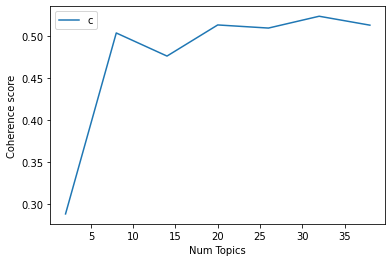

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2878
Num Topics = 8  has Coherence Value of 0.5038
Num Topics = 14  has Coherence Value of 0.4762
Num Topics = 20  has Coherence Value of 0.5134
Num Topics = 26  has Coherence Value of 0.5097
Num Topics = 32  has Coherence Value of 0.5238
Num Topics = 38  has Coherence Value of 0.5131


In [29]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.023*"strike" + 0.015*"day" + 0.010*"public" + 0.009*"today" + '
  '0.009*"service" + 0.008*"hour" + 0.008*"travel" + 0.008*"staff" + '
  '0.008*"close" + 0.008*"check"'),
 (1,
  '0.025*"woman" + 0.020*"man" + 0.018*"family" + 0.015*"child" + 0.015*"life" '
  '+ 0.014*"day" + 0.011*"time" + 0.010*"friend" + 0.010*"live" + '
  '0.009*"find"'),
 (2,
  '0.012*"water" + 0.012*"food" + 0.008*"energy" + 0.007*"world" + '
  '0.007*"scientist" + 0.007*"find" + 0.006*"high" + 0.006*"oil" + '
  '0.006*"research" + 0.006*"study"'),
 (3,
  '0.013*"site" + 0.013*"comment" + 0.012*"twitter" + 0.012*"internet" + '
  '0.012*"company" + 0.011*"online" + 0.010*"user" + 0.010*"datum" + '
  '0.009*"picture" + 0.009*"include"'),
 (4,
  '0.013*"world" + 0.011*"state" + 0.010*"people" + 0.010*"country" + '
  '0.008*"political" + 0.008*"change" + 0.008*"power" + 0.007*"issue" + '
  '0.006*"society" + 0.005*"future"'),
 (5,
  '0.024*"government" + 0.020*"labour" + 0.017*"vote" + 0.016*"party" + '
  '0

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.0654,"news, world, police, newspaper, journalist, ed...",His whistleblower friend needed the money He h...
1,1,0.0,0.0500,"strike, day, public, today, service, hour, tra...",Mr Blobby Earth Song by Michael Jackson Can We...
2,2,0.0,0.6191,"strike, day, public, today, service, hour, tra...",Thousands of schools closed across south east ...
3,3,15.0,0.4261,"pm, game, time, team, play, back, set, player,...","Internazionale were drawn against Chelsea, whi..."
4,4,0.0,0.5245,"strike, day, public, today, service, hour, tra...",The Scottish airline Flyglobespan has gone int...
5,5,2.0,0.1355,"water, food, energy, world, scientist, find, h...",Channel retro wartime chic with an Anderson sh...
6,6,3.0,0.1542,"site, comment, twitter, internet, company, onl...",We have switched off comments on this old vers...
7,7,18.0,0.1132,"film, book, show, love, good, music, play, cha...","The crash, the snow, Obamas victory and Flinto..."
8,8,7.0,0.3291,"court, case, claim, legal, evidence, lawyer, l...",CRCheck asks: I continued to be annoyed at TV ...
9,9,9.0,0.3700,"protest, protester, people, police, street, re...",• 230 climate activists have been arrested for...


In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7737,"strike, day, public, today, service, hour, tra...",Further snow and freezing weather has gridlock...
1,1.0,0.5216,"woman, man, family, child, life, day, time, fr...","Just before I turned six, Molly disappeared. I..."
2,2.0,0.6407,"water, food, energy, world, scientist, find, h...",Billions of trees died in the record drought t...
3,3.0,0.6675,"site, comment, twitter, internet, company, onl...",</div> <script> // send the query string to th...
4,4.0,0.4767,"world, state, people, country, political, chan...",A spectre is haunting Europe – the spectre of ...


In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,10.0,"news, world, police, newspaper, journalist, ed...",1717.0,0.1453
1.0,0.0,"strike, day, public, today, service, hour, tra...",544.0,0.0460
2.0,0.0,"strike, day, public, today, service, hour, tra...",726.0,0.0615
3.0,15.0,"pm, game, time, team, play, back, set, player,...",1283.0,0.1086
4.0,0.0,"strike, day, public, today, service, hour, tra...",339.0,0.0287
...,...,...,...,...
11809.0,6.0,"police, people, riot, officer, night, man, sel...",NaN,NaN
11810.0,0.0,"strike, day, public, today, service, hour, tra...",NaN,NaN
11811.0,8.0,"ball, run, good, play, day, back, single, wick...",NaN,NaN
11812.0,0.0,"strike, day, public, today, service, hour, tra...",NaN,NaN
